✅ Loaded 172 training and 121 testing images.
📂 Classes: ['defect', 'notdefect']


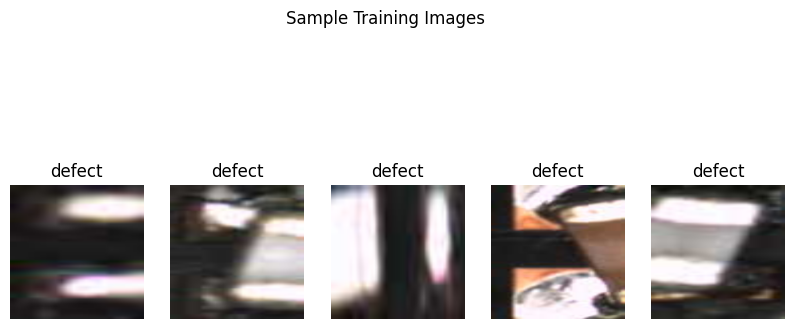

💻 Using device: cpu
Epoch [1/5] | Train Loss: 0.7801 | Val Loss: 0.2000
Epoch [2/5] | Train Loss: 0.2644 | Val Loss: 0.6436
Epoch [3/5] | Train Loss: 0.2797 | Val Loss: 0.1113
Epoch [4/5] | Train Loss: 0.0291 | Val Loss: 0.0660
Epoch [5/5] | Train Loss: 0.0371 | Val Loss: 0.1532


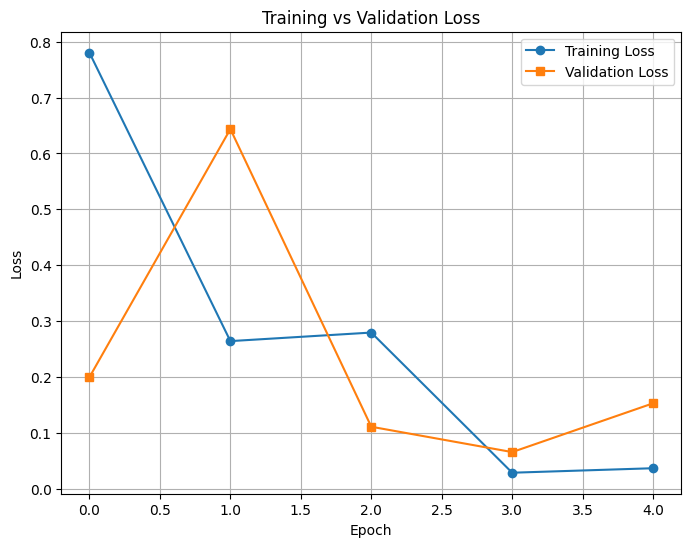


✅ Test Accuracy: 97.52%


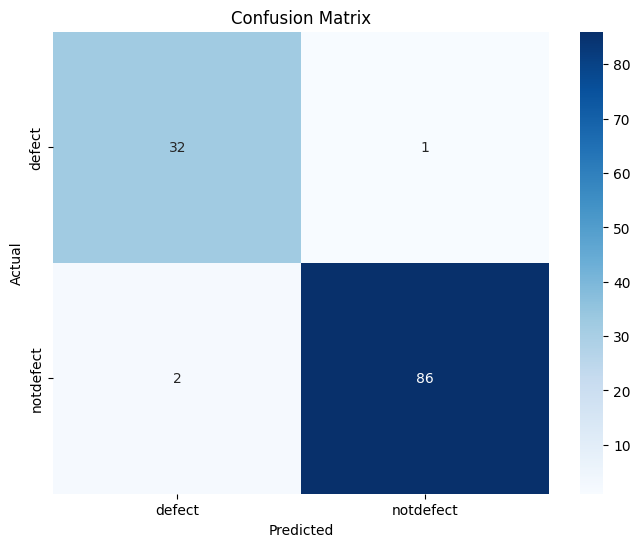


Classification Report:
              precision    recall  f1-score   support

      defect       0.94      0.97      0.96        33
   notdefect       0.99      0.98      0.98        88

    accuracy                           0.98       121
   macro avg       0.96      0.97      0.97       121
weighted avg       0.98      0.98      0.98       121



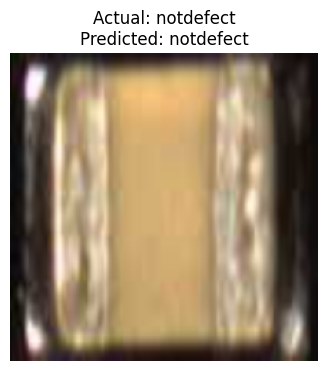

🖼️ Actual: notdefect | Predicted: notdefect


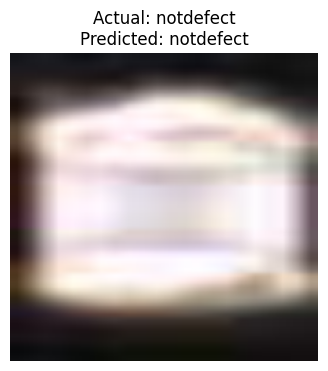

🖼️ Actual: notdefect | Predicted: notdefect


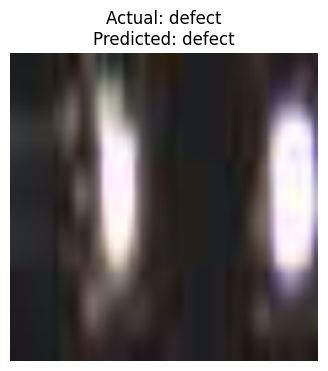

🖼️ Actual: defect | Predicted: defect


In [1]:

# ================================================================
# Step 1: Import Required Libraries
# ================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import models, datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import zipfile, os, random
from PIL import Image

# ================================================================
# Step 2: Extract Dataset (Windows-Compatible)
# ================================================================
zip_path = "chip_data.zip"       # <-- your uploaded file
extract_path = "./data"

# Extract ZIP if not already extracted
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Dataset extracted successfully!")

dataset_path = os.path.join(extract_path, "dataset")

if not os.path.exists(dataset_path):
    raise FileNotFoundError("❌ Folder './data/dataset' not found. Ensure ZIP contains dataset/train and dataset/test folders.")

# ================================================================
# Step 3: Define Image Transformations
# ================================================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ================================================================
# Step 4: Load Train and Test Datasets
# ================================================================
train_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "train"), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"✅ Loaded {len(train_dataset)} training and {len(test_dataset)} testing images.")
print("📂 Classes:", train_dataset.classes)

# ================================================================
# Step 5: Display Sample Images
# ================================================================
def show_sample_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))
    for i in range(num_images):
        image, label = dataset[i]
        axes[i].imshow(image.permute(1, 2, 0))
        axes[i].set_title(dataset.classes[label])
        axes[i].axis("off")
    plt.suptitle("Sample Training Images")
    plt.show()

show_sample_images(train_dataset)

# ================================================================
# Step 6: Load Pretrained Model (VGG19)
# ================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("💻 Using device:", device)

model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)

# Freeze convolutional layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace final layer for our dataset
num_classes = len(train_dataset.classes)
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
model = model.to(device)

# ================================================================
# Step 7: Define Loss Function and Optimizer
# ================================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# ================================================================
# Step 8: Train the Model
# ================================================================
def train_model(model, train_loader, test_loader, num_epochs=5):
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()

        train_loss = running_loss / len(train_loader)
        val_loss = val_loss / len(test_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Plot Training & Validation Loss vs Epochs
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

# Start training
model = train_model(model, train_loader, test_loader, num_epochs=5)

# ================================================================
# Step 9: Evaluate Model - Confusion Matrix & Classification Report
# ================================================================
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Evaluate model performance
evaluate_model(model, test_loader)

# ================================================================
# Step 10: Predict Random Test Images
# ================================================================
def predict_random_image(model, dataset):
    idx = random.randint(0, len(dataset) - 1)
    image, label = dataset[idx]
    image_input = image.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_input)
        _, predicted = torch.max(output, 1)

    pred_class = dataset.classes[predicted.item()]
    actual_class = dataset.classes[label]

    plt.figure(figsize=(4, 4))
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"Actual: {actual_class}\nPredicted: {pred_class}")
    plt.axis("off")
    plt.show()

    print(f"🖼️ Actual: {actual_class} | Predicted: {pred_class}")

# Predict 3 random images from test dataset
for _ in range(3):
    predict_random_image(model, test_dataset)
